In [21]:
#!pip install psycopg2


In [22]:
import psycopg2
import pandas as pd
import numpy as np
import csv

### verify the conexion
try:
    # Connect to the database
    conn = psycopg2.connect(
        host="pg.ujueta.com",
        port="5432",
        user="consultoria",
        password="LmKTXJBXya!14]f9!2k]",
        database="postgres",
    )
except psycopg2.Error as e:
    print("Error connecting to the database:")
    print(e)
else:
    print("Connection established successfully")

Connection established successfully


In [23]:

### ventas diario apiladas
def export_forecast_to_csv():
    try:
        # connect to the database
        conn = psycopg2.connect(
            host="pg.ujueta.com",
            port="5432",
            user="consultoria",
            password="LmKTXJBXya!14]f9!2k]",
            database="postgres",
        )

        # create cursor
        with conn.cursor() as cur:

            # ececute a sql query

            cur.execute("""SELECT * FROM forecast.ventas_diario WHERE docdate BETWEEN '2015-01-01' AND '2024-11-30' """)

            # fetch the results
            results = cur.fetchall()

            # open a file in the downloads folder

            with open(
                r"C:\Users\Alberto Florez\OneDrive\Documentos\GitHub\input_high.csv",
                #"/home/usuario/Escritorio/Consultorias_Empresariales/Ujueta/Datos/input_high.csv",
                "w",
                newline="",
            ) as f:
                # create a csv writer
                writer = csv.writer(f)

                # write the column names
                writer.writerow([col[0] for col in cur.description])

                # write the query results
                writer.writerows(results)
    except Exception as e:
        print(f"An error ocurred: {e}")
    finally:
        # close the cursor and connection
        if conn:
            conn.close()


# Call the function to export data to csv
export_forecast_to_csv()


In [24]:
### manipulate data

import pandas as pd

# carga de datas
data = pd.read_csv(
    r"C:\Users\Alberto Florez\OneDrive\Documentos\GitHub\input_high.csv"
    #"/home/usuario/Escritorio/Consultorias_Empresariales/Ujueta/Datos/input_high.csv"
)
# convertir en dataframe
df = pd.DataFrame(data)
df.head()

,docdate,codigo_articulo,cantidad
0,2022-01-03,AUACALR4,1
1,2022-01-03,AUACCH1,5
2,2022-01-03,AUACPB400,1
3,2022-01-03,AUACRIM4F,5
4,2022-01-03,AUACSH1000,3


In [25]:
df.shape

(89180, 3)

In [26]:
import pandas as pd

def sumarizar_a_mensual(df, fecha_col, suma_col, agrupar_por=None):
    """
    Función para sumarizar datos diarios a un nivel mensual.

    Parámetros:
    ----------
    df : pd.DataFrame
        El DataFrame de entrada con los datos a procesar.
    fecha_col : str
        Nombre de la columna que contiene las fechas.
    suma_col : str
        Nombre de la columna cuyos valores se desean sumarizar.
    agrupar_por : list, optional
        Lista de columnas adicionales para agrupar (por defecto es None).
    
    Retorna:
    -------
    pd.DataFrame
        DataFrame con los datos agregados a nivel mensual.
    """
    # Asegurar que la columna de fecha esté en formato datetime
    df[fecha_col] = pd.to_datetime(df[fecha_col], errors='coerce')
    
    # Filtrar filas con fechas válidas
    df = df.dropna(subset=[fecha_col])
    
    # Crear la clave de agrupación mensual
    df['mes_inicio'] = df[fecha_col].dt.to_period('M').dt.to_timestamp()

    # Configurar las columnas para agrupar
    group_cols = ['mes_inicio'] + (agrupar_por if agrupar_por else [])

    # Realizar la agrupación y sumarización
    resultado = (
        df.groupby(group_cols, as_index=False)[suma_col]
        .sum()
    )

    return resultado


In [27]:
# List of SKUs to filter
selected_skus = [
    'AUACAE30', 'AUACPB400', 'AUACRIM4F', 'AUACSH1000', 'HEELAG1141',
    'HEELAG1142KIT', 'HEELPW1770', 'HEELXID20', 'HEFUFCD12KIT',
    'HEFUFCD21', 'HEFUFD52', 'HEFUFG71', 'SOELCSVM501', 'SOELCSVM530',
    'SOELSI6140DV', 'SOFUFW181', 'SOFUFW185', 'SOFUFW33', 'SOFUFW35',
    'SOSWP2-517'
]

# Filter the dataset
filtered_df = df[df['codigo_articulo'].isin(selected_skus)]
#filtered_df.rename(columns={'mes_inicio': 'docdate'}, inplace=True)

In [28]:
print(filtered_df)

          docdate codigo_articulo  cantidad
2      2022-01-03       AUACPB400         1
3      2022-01-03       AUACRIM4F         5
4      2022-01-03      AUACSH1000         3
10     2022-01-03      HEELAG1141        56
22     2022-01-03      HEELPW1770         4
...           ...             ...       ...
89134  2024-11-30       SOFUFW181       927
89135  2024-11-30       SOFUFW185        21
89139  2024-11-30        SOFUFW33       246
89140  2024-11-30        SOFUFW35        45
89173  2024-11-30      SOSWP2-517        32

[13297 rows x 3 columns]


In [29]:
data_highdda = filtered_df.copy() #[filtered_df['docdate'] >= '2022-01-01']
data_highdda

,docdate,codigo_articulo,cantidad
2,2022-01-03,AUACPB400,1
3,2022-01-03,AUACRIM4F,5
4,2022-01-03,AUACSH1000,3
10,2022-01-03,HEELAG1141,56
22,2022-01-03,HEELPW1770,4
...,...,...,...
89134,2024-11-30,SOFUFW181,927
89135,2024-11-30,SOFUFW185,21
89139,2024-11-30,SOFUFW33,246
89140,2024-11-30,SOFUFW35,45


In [30]:
#========================================================================================================================================
# Ajuste de Datos para statsforecast
#========================================================================================================================================

#-- Dato de ejemplo para función

def data_sf(df, date = 'docdate', y = 'cantidad', unique_id = 'codigo_articulo'):
    df_m = df[[date, y, unique_id]]
    df_m.rename(columns={date : 'ds', y :'y', unique_id: 'unique_id'}, inplace=True)
  
    return df_m

df_m = data_sf(data_highdda, date = 'docdate', y = 'cantidad', unique_id = 'codigo_articulo')
df_m
df_m.info()




<class 'pandas.core.frame.DataFrame'>
Index: 13297 entries, 2 to 89173
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ds         13297 non-null  object
 1   y          13297 non-null  int64 
 2   unique_id  13297 non-null  object
dtypes: int64(1), object(2)
memory usage: 415.5+ KB


In [31]:
#========================================================================================================================================
# Colección de modelos
#========================================================================================================================================
from statsforecast import StatsForecast #- Para instanciar los  modelos
from statsforecast.models import Naive

from statsforecast.models import (
    AutoARIMA,
    AutoETS,
    HoltWinters,
    ADIDA,
    CrostonClassic as Croston, 
    IMAPA,
    TSB,
    HistoricAverage,
    DynamicOptimizedTheta as DOT,
    Naive,
    SeasonalNaive,
    Theta,
    WindowAverage,
    Holt,
    CrostonOptimized,
)

#-- Parametros

# Número de días en el futuro a pronosticar
horizon = 30
# Ventana estacional: es 12 porque tenemos datos son mensuales
season_length = 7
# El número de dias que el modelo usará para hacer el forecast 
window_size = 6*30

# Lista de modelos a evaluar
models = [
    AutoARIMA(season_length=season_length),
    AutoETS(season_length=season_length),
    HoltWinters(season_length=season_length),
    # ADIDA(),
    # Croston(),
    # IMAPA(),
    # TSB(alpha_d = 0.2, alpha_p = 0.2),
    # HistoricAverage(),
    # DOT(season_length=season_length),
    # Naive(),
    # SeasonalNaive(season_length=season_length),
    # Theta(),
    #WindowAverage(window_size=7),  # Adjust `window_size` as needed
    Holt() #,
    #CrostonOptimized()
]

In [32]:
# StatsForecast.plot(df_m)

# Instanciando StatsForecast como sf
sf = StatsForecast( 
    models=models,
    freq='D', #MS
    n_jobs=-1,
)


In [33]:
# Cross Validation
from functools import partial
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mape, mase, mse, smape

crossvaldation_df = sf.cross_validation(
    df=df_m,
    h=horizon,
    step_size=horizon,
    n_windows=3
)



C:\Users\Alberto Florez\AppData\Roaming\Python\Python312\site-packages\statsforecast\core.py:494: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [34]:
def evaluate_cross_validation(df, metric):
    models = df.drop(columns=['unique_id', 'ds', 'cutoff', 'y'], errors='ignore').columns.tolist()
    evals = []
    # Calculate loss for every unique_id and cutoff.    
    for cutoff in df['cutoff'].unique():
        eval_ = evaluate(df[df['cutoff'] == cutoff], metrics=[metric], models=models)
        evals.append(eval_)
    evals = pd.concat(evals)
    evals = evals.groupby('unique_id').mean(numeric_only=True) # Averages the error metrics for all cutoffs for every combination of model and unique_id
    evals['best_model'] = evals.idxmin(axis=1)
    return evals

evaluation_df = evaluate_cross_validation(crossvaldation_df.reset_index(drop=False), smape)
evaluation_df.head(22)

,AutoARIMA,AutoETS,HoltWinters,Holt,best_model
unique_id,,,,,
AUACAE30,0.445959,0.481906,0.479989,0.483164,AutoARIMA
AUACPB400,0.557531,0.382453,0.386658,0.384949,AutoETS
AUACRIM4F,0.658702,0.344232,0.363352,0.363484,AutoETS
AUACSH1000,0.659902,0.491091,0.498504,0.496455,AutoETS
HEELAG1141,0.584521,0.694395,0.695732,0.705524,AutoARIMA
HEELAG1142KIT,0.624920,0.650492,0.654382,0.650492,AutoARIMA
HEELPW1770,0.599007,0.628940,0.625131,0.624188,AutoARIMA
HEELXID20,0.395176,0.391407,0.394372,0.396955,AutoETS
HEFUFCD12KIT,0.524800,0.466017,0.483910,0.482621,AutoETS


In [35]:
#--- Selección del mejor modelo
fcst_df = sf.forecast(df=df_m, 
                      h=90, 
                      ## level=[90]
                     )
fcst_df.head()

C:\Users\Alberto Florez\AppData\Roaming\Python\Python312\site-packages\statsforecast\core.py:494: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,ds,AutoARIMA,AutoETS,HoltWinters,Holt
unique_id,,,,,
AUACAE30,2024-12-01,8.371451,8.466929,9.340794,8.501479
AUACAE30,2024-12-02,8.371450,8.466929,10.271025,8.504398
AUACAE30,2024-12-03,8.371449,8.466929,7.165808,8.506736
AUACAE30,2024-12-04,8.371449,8.466929,11.254182,8.508608
AUACAE30,2024-12-05,8.371448,8.466929,6.637053,8.510106


In [36]:
#-- Revisión para eliminar pornosticos constantes
fcst_df.reset_index(drop=False).groupby(['unique_id']).std()

,ds,AutoARIMA,AutoETS,HoltWinters,Holt
unique_id,,,,,
AUACAE30,26 days 02:59:34.162531549,0.000026,0.000000,1.681595,0.002457
AUACPB400,26 days 02:59:34.162531549,1.426525,0.000000,0.505264,0.000881
AUACRIM4F,26 days 02:59:34.162531549,0.829370,0.000000,3.457947,2.296263
AUACSH1000,26 days 02:59:34.162531549,2.057295,0.000000,1.757083,0.002158
HEELAG1141,26 days 02:59:34.162531549,4.630327,3.627831,3.656956,0.032281
HEELAG1142KIT,26 days 02:59:34.162531549,0.000000,0.000000,5.459402,2.689426
HEELPW1770,26 days 02:59:34.162531549,8.501214,0.000000,1.204488,0.430139
HEELXID20,26 days 02:59:34.162531549,0.000000,0.000000,0.913560,0.086219
HEFUFCD12KIT,26 days 02:59:34.162531549,4.523434,0.000000,4.298819,1.605437


C:\Users\Alberto Florez\AppData\Roaming\Python\Python312\site-packages\statsforecast\core.py:1407: FutureWarning: Passing the ids as the index is deprecated. Please provide them as a column instead.
  warnings.warn(


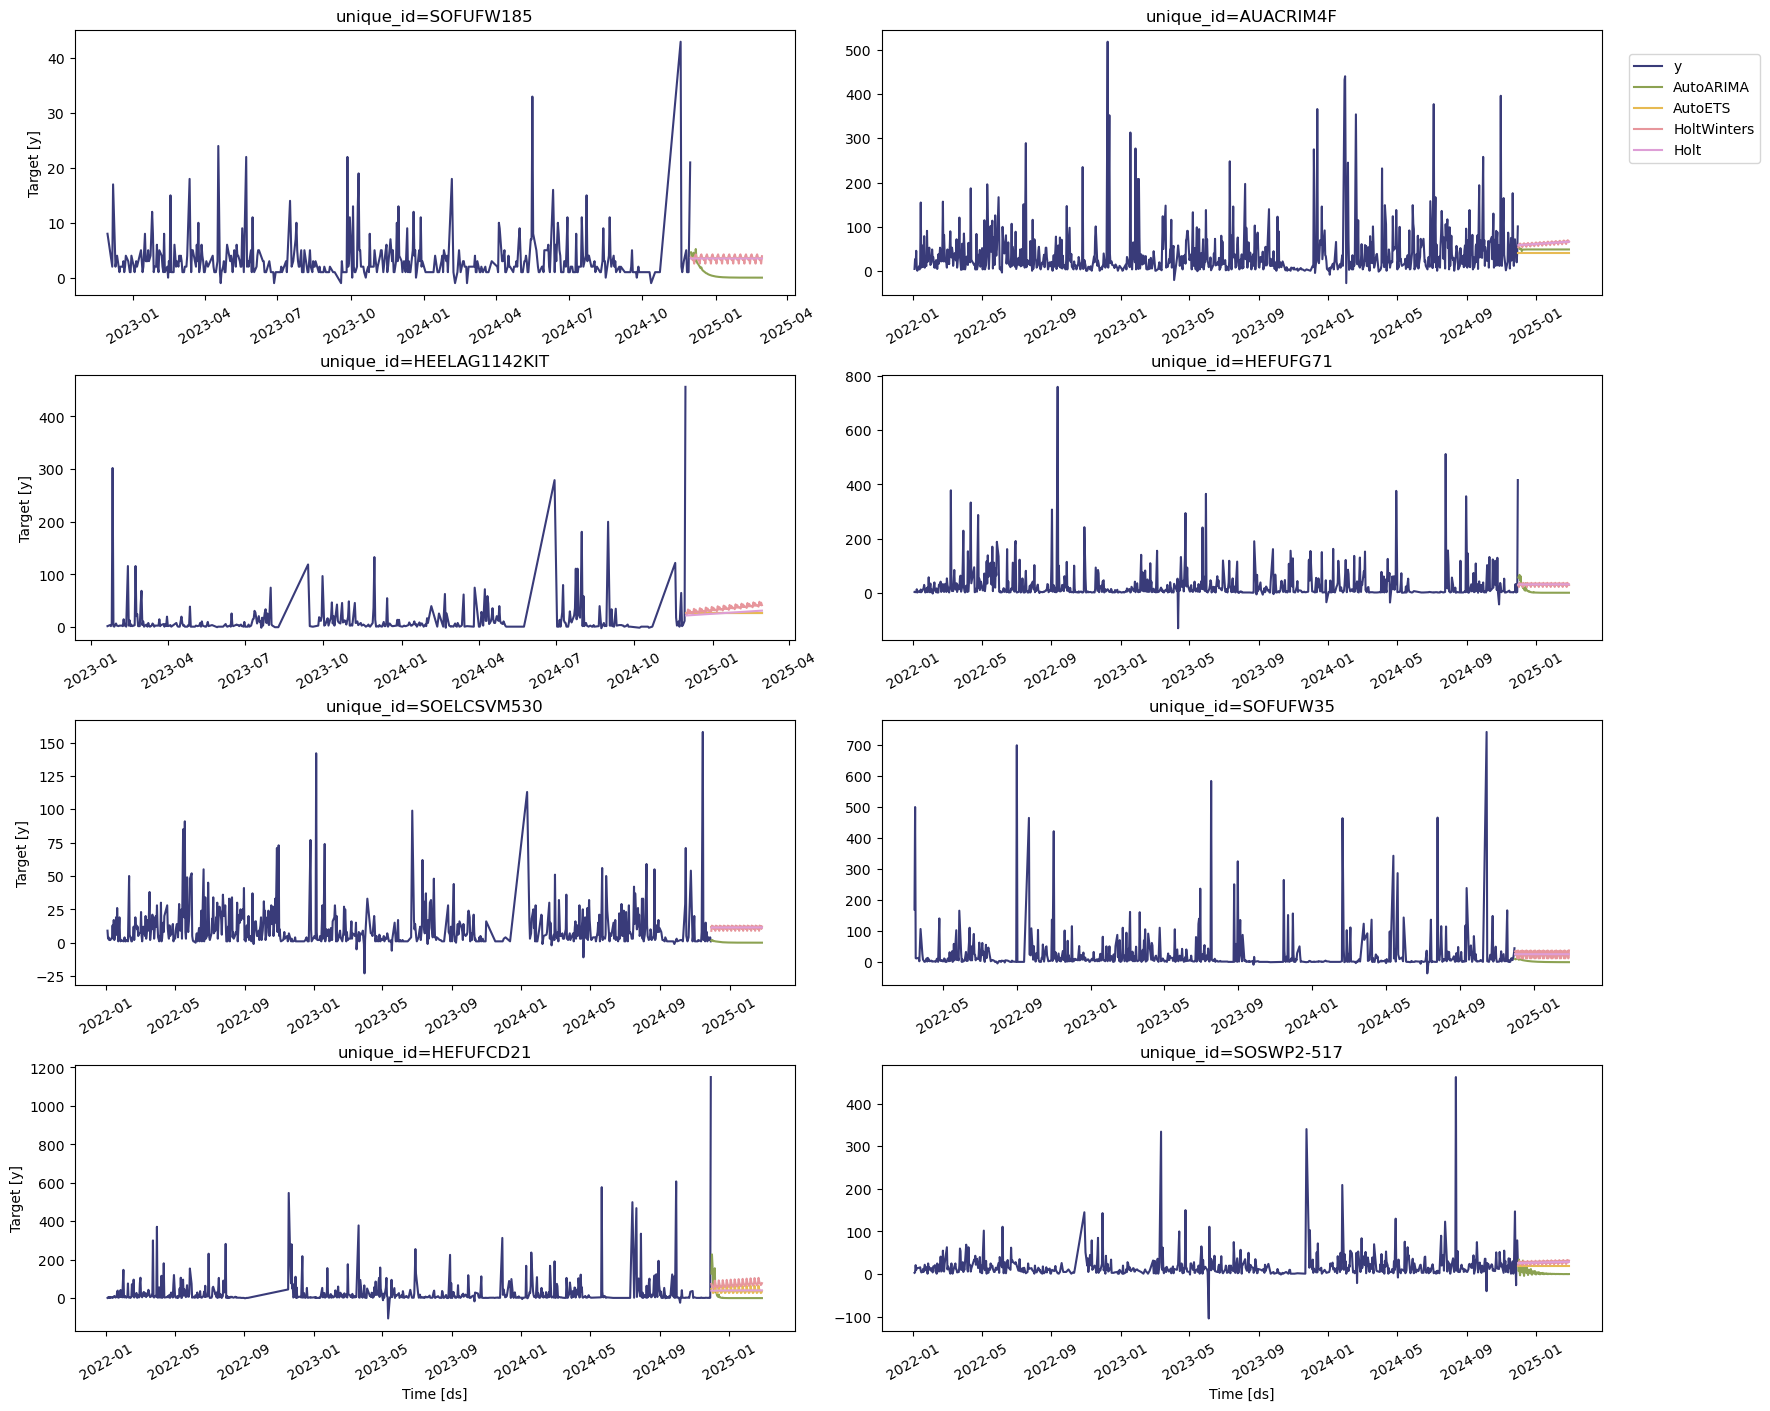

In [37]:
sf.plot(df_m,fcst_df)

In [38]:
def get_best_model_forecast(forecasts_df, evaluation_df):
    # Clean and standardize column names
    forecasts_df.columns = forecasts_df.columns.str.strip().str.lower()
    evaluation_df['best_model'] = evaluation_df['best_model'].str.strip().str.lower()
    
    # Reset index to ensure 'unique_id' is a column
    forecasts_df = forecasts_df.reset_index()
    
    # Merge evaluation_df with forecasts_df
    merged_df = evaluation_df.merge(forecasts_df, on='unique_id', how='left')
    
    rows = []
    for _, row in merged_df.iterrows():
        best_model = row['best_model']
        
        # Validate best_model column
        if best_model not in forecasts_df.columns:
            raise KeyError(f"Model '{best_model}' not found in forecasts_df columns: {forecasts_df.columns.tolist()}")
        
        # Append the forecast value for the best model
        rows.append({'unique_id': row['unique_id'], 'ds': row['ds'], 'best_model': row[best_model]})
    
    # Convert to a dataframe
    result_df = pd.DataFrame(rows)
    return result_df

# Example usage
prod_forecasts_df = get_best_model_forecast(forecasts_df=fcst_df, evaluation_df=evaluation_df)
prod_forecasts_df['best_model'] = np.where(prod_forecasts_df['best_model']<0, 0, prod_forecasts_df['best_model'].round())
prod_forecasts_df

,unique_id,ds,best_model
0,AUACAE30,2024-12-01,8.0
1,AUACAE30,2024-12-02,8.0
2,AUACAE30,2024-12-03,8.0
3,AUACAE30,2024-12-04,8.0
4,AUACAE30,2024-12-05,8.0
...,...,...,...
1795,SOSWP2-517,2025-02-24,30.0
1796,SOSWP2-517,2025-02-25,33.0
1797,SOSWP2-517,2025-02-26,27.0
1798,SOSWP2-517,2025-02-27,28.0


In [39]:
# Usar la función de agregación mensual

prod_forecasts_df_m = sumarizar_a_mensual(prod_forecasts_df, 
    fecha_col='ds', 
    suma_col='best_model', 
    agrupar_por=['unique_id']
)
print(prod_forecasts_df_m)

   mes_inicio    unique_id  best_model
0  2024-11-01  SOELCSVM501        17.0
1  2024-11-01  SOELCSVM530        11.0
2  2024-12-01     AUACAE30       248.0
3  2024-12-01    AUACPB400       155.0
4  2024-12-01    AUACRIM4F      1271.0
..        ...          ...         ...
57 2025-02-01    SOFUFW181      1512.0
58 2025-02-01    SOFUFW185       112.0
59 2025-02-01     SOFUFW33      1644.0
60 2025-02-01     SOFUFW35         0.0
61 2025-02-01   SOSWP2-517       797.0

[62 rows x 3 columns]


In [ ]:
prod_forecasts_df_m.to_excel("../output_DemandHigh_08122024.xlsx", sheet_name='PronosticoMensual')